In [160]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import WhitespaceTokenizer
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from collections import Counter

In [108]:
pd.set_option('display.max_colwidth', 500)

## Import file
- Only keep rows with non-null titles and abstracts
- Make title and abstracts lowercase

In [109]:
m = pd.read_csv('metadata.csv')

In [111]:
m = m[(m['title'].notna() & m['abstract'].notna())]

In [112]:
m['title'] = m['title'].str.lower()
m['abstract'] = m['abstract'].str.lower()

## Lemmatize Abstracts and Titles (get word roots)

In [113]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [114]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [116]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stop_words]

In [117]:
def lemmatized_string(lemmatized_list):
    return ' '.join(word for word in lemmatized_list)

In [118]:
m['title_lemmatized'] = m['title'].apply(lemmatize_text)
m['abstract_lemmatized'] = m['abstract'].apply(lemmatize_text)

In [119]:
m['title_lemmatized_string'] = m['title_lemmatized'].apply(lemmatized_string)
m['abstract_lemmatized_string'] = m['abstract_lemmatized'].apply(lemmatized_string)

## Word Cloud - Generic

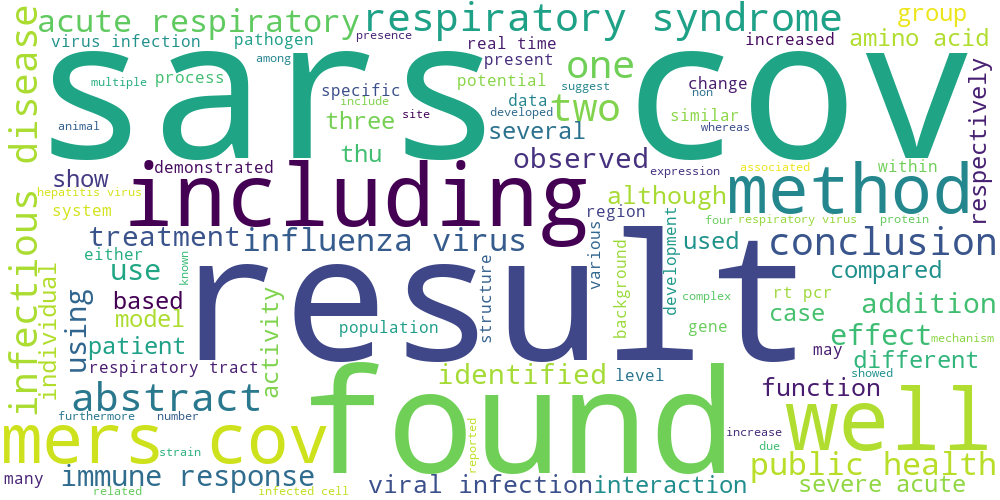

In [121]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(m['abstract_lemmatized_string'].values))
# Create a WordCloud object
wordcloud = WordCloud(width = 1000, height = 500, 
                      background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Coherence Score to Select # of Topics for LDA Model

*Note: need to use gensim LDA model for coherence score. but using sklearn model for other parts. not perfect but good enough for now*

In [122]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(m['abstract_lemmatized'])

In [123]:
common_corpus = [common_dictionary.doc2bow(text) for text in m['abstract_lemmatized']]

In [124]:
def get_coherence_scores(common_corpus, min_num_topics, max_num_topics, common_dictionary, texts):
    topic_coherence_dictionary = {}
    for x in range(min_num_topics, max_num_topics):
        model = gensim.models.LdaModel(common_corpus, x, common_dictionary)
        coherence_model_lda = CoherenceModel(model=model,
                                            corpus=common_corpus,
                                            dictionary=common_dictionary,
                                            texts=texts,
                                            coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        topic_coherence_dictionary[x] = coherence_lda
    return topic_coherence_dictionary

In [177]:
# coherence = get_coherence_scores(common_corpus, 1, 101, common_dictionary, m['abstract_lemmatized'])

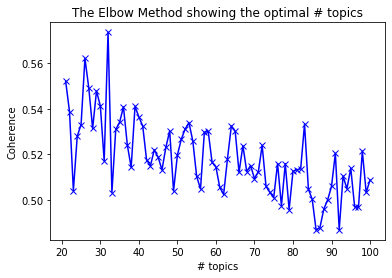

In [179]:
# Plot the elbow
plt.plot(list(coherence.keys()), list(coherence.values()), 'bx-')
plt.xlabel('# topics')
plt.ylabel('Coherence')
plt.title('The Elbow Method showing the optimal # topics')
plt.show()

## Max @ 32. Local maxes before @ 15 & 26

In [180]:
best_num_topics = max(coherence, key=coherence.get)

In [181]:
best_num_topics

32

## LDA on abstracts - use best number of topics from coherence

In [127]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [182]:
# Tweak the two parameters below
number_topics_abstract = best_num_topics
number_words_abstract = 10

In [183]:
count_vectorizer_abstract = CountVectorizer(stop_words='english')
count_data_abstract = count_vectorizer_abstract.fit_transform(m['abstract_lemmatized_string'])

In [184]:
# Create and fit the LDA model
lda_abstract = LDA(n_components=number_topics_abstract, n_jobs=-1)
lda_abstract.fit(count_data_abstract)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=32, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [185]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_abstract, count_vectorizer_abstract, number_words_abstract)

Topics found via LDA:

Topic #0:
il effect activity anti protein induced expression cell level extract

Topic #1:
drug antiviral hiv treatment activity compound therapeutic therapy development inhibitor

Topic #2:
virus bat genome sequence analysis host gene specie human genetic

Topic #3:
le et la en une dans est pa par ca

Topic #4:
mers case infection patient hospital cov outbreak respiratory transmission control

Topic #5:
vaccine response antibody immune vaccination antigen specific protection challenge immunity

Topic #6:
model data disease epidemic transmission outbreak number time population network

Topic #7:
group day serum antibody blood 10 cat study elisa level

Topic #8:
dog canine feline cpv cat type study parvovirus dogs sample

Topic #9:
protein mass analysis ms using acid spectrometry plasma used biomarkers

Topic #10:
hcv peptide zikv lipid protein activity membrane sirna hev rna

Topic #11:
herd infection farm pregnancy incidence birth study prevalence maternal disea

## Looking for Topic associated with NPI + modelling efforts

In [186]:
topics = lda_abstract.transform(count_data_abstract)

In [187]:
for idx in range(number_topics_abstract):
    col_name = 'Topic ' + str(idx) + ' Strength'
    m[col_name] = topics[:, idx]

## Most basic - non-pharm in title

In [203]:
non_pharm = m[(m['abstract'].str.contains('non-pharm')) & (m['abstract'].str.contains('model'))]

In [204]:
non_pharm_topic_cols = [x for x in non_pharm.columns if 'Topic' in x]

In [205]:
non_pharm_topics = non_pharm[non_pharm_topic_cols].idxmax(axis=1)

In [206]:
def most_frequent(List): 
    return max(set(List), key = List.count) 

## Take the topics that match most for NPI modeling papers, then find all papers with that as their top topic

In [207]:
Counter(non_pharm_topics)

Counter({'Topic 6 Strength': 9,
         'Topic 15 Strength': 6,
         'Topic 20 Strength': 5})

In [208]:
top_topic = most_frequent(list(non_pharm_topics))

top_topic

'Topic 6 Strength'

In [253]:
m_top_topics_find = pd.DataFrame(m[non_pharm_topic_cols].idxmax(axis=1))

In [257]:
m_npi_top_topic_idxs = list(m_top_topics_find[m_top_topics_find[0] == top_topic].index)

In [258]:
top_topic_papers = m.ix[m_npi_top_topic_idxs]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [259]:
top_topic_papers[top_topic].mean()

0.5588938355008991

In [260]:
len(top_topic_papers)

1479

## What more specific keywords can we pull out of this topic?

## Title

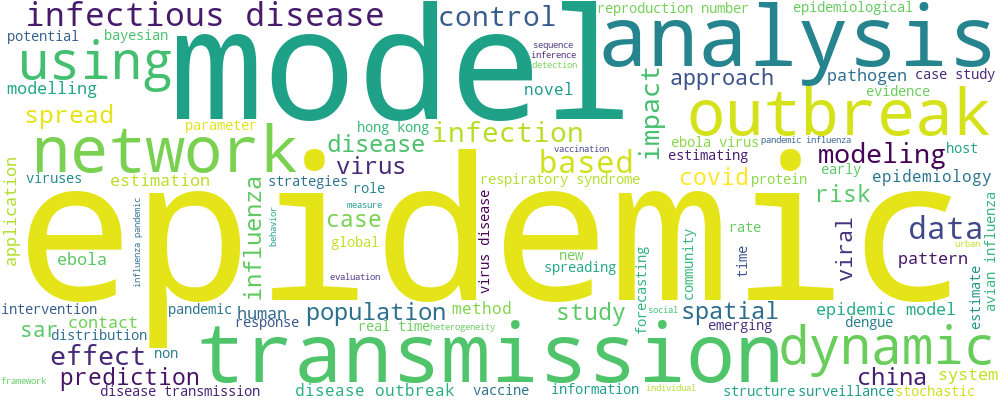

In [262]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(top_topic_papers['title'].values))
# Create a WordCloud object
wordcloud = WordCloud(width = 1000, height = 400, 
                      background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Abstract

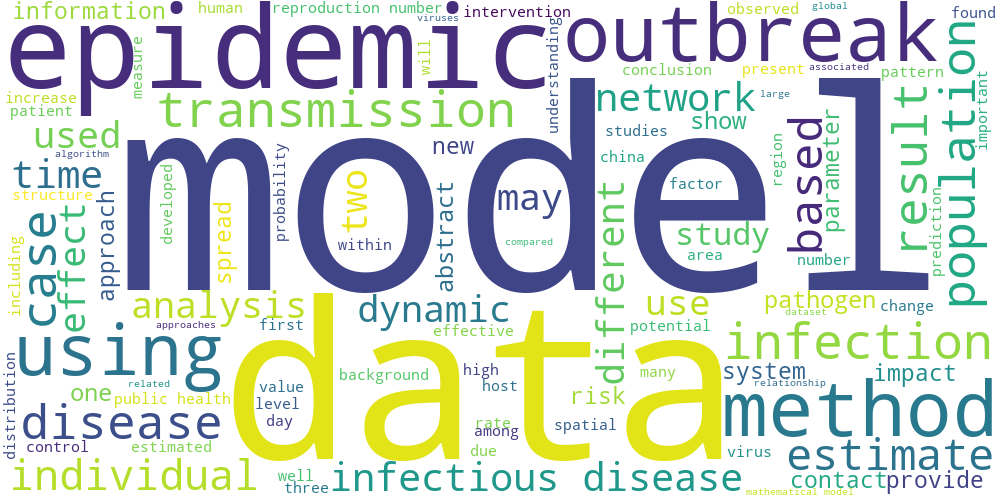

In [263]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(top_topic_papers['abstract'].values))
# Create a WordCloud object
wordcloud = WordCloud(width = 1000, height = 500, 
                      background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Keyword Search

- R0, basic reproduction number, R 0, R_0
- Growth rate, r, doubling time
- Incubation period


In [280]:
model_keywords = ['R0', 'basic reproduction number', 'R 0', 'R_0', 'Growth rate', ' r ', 'doubling time', 
                     'Incubation period']

In [283]:
def find_papers_w_keywords(keywords, metadata):
    for keyword in keywords:
        num_papers_title = len(metadata[metadata['title'].str.contains(keyword)])
        num_papers_abstract = len(metadata[metadata['abstract'].str.contains(keyword)])
        print ('Identified {} papers with "{}" in title, {} relevant papers with "{}" in abstract'\
                       .format(num_papers_title, keyword, num_papers_abstract, keyword)) 

## Look at relevant topic papers

In [284]:
find_papers_w_keywords(model_keywords, top_topic_papers)

Identified 0 papers with "R0" in title, 0 relevant papers with "R0" in abstract
Identified 8 papers with "basic reproduction number" in title, 83 relevant papers with "basic reproduction number" in abstract
Identified 0 papers with "R 0" in title, 0 relevant papers with "R 0" in abstract
Identified 0 papers with "R_0" in title, 0 relevant papers with "R_0" in abstract
Identified 0 papers with "Growth rate" in title, 0 relevant papers with "Growth rate" in abstract
Identified 7 papers with " r " in title, 82 relevant papers with " r " in abstract
Identified 1 papers with "doubling time" in title, 2 relevant papers with "doubling time" in abstract
Identified 0 papers with "Incubation period" in title, 0 relevant papers with "Incubation period" in abstract


## Look at all papers

In [282]:
find_papers_w_keywords(model_keywords, m)

Identified 0 NPI papers with "R0" in title, 0 relevant papers with "R0" in abstract
Identified 15 NPI papers with "basic reproduction number" in title, 143 relevant papers with "basic reproduction number" in abstract
Identified 0 NPI papers with "R 0" in title, 0 relevant papers with "R 0" in abstract
Identified 0 NPI papers with "R_0" in title, 0 relevant papers with "R_0" in abstract
Identified 0 NPI papers with "Growth rate" in title, 0 relevant papers with "Growth rate" in abstract
Identified 19 NPI papers with " r " in title, 219 relevant papers with " r " in abstract
Identified 3 NPI papers with "doubling time" in title, 19 relevant papers with "doubling time" in abstract
Identified 0 NPI papers with "Incubation period" in title, 0 relevant papers with "Incubation period" in abstract


## Identify relevant papers

In [285]:
# 0 for title search, 1 for abstract search
def return_papers(selected_keyword, metadata, abstract_search=1):
    if abstract_search == 1:
        return metadata[['title', 'abstract', 'sha']][metadata['abstract'].str.contains(selected_keyword)]
    else:
        return metadata[['title', 'abstract', 'sha']][metadata['title'].str.contains(selected_keyword)]

## Relevant Topic Papers

In [286]:
return_papers('doubling time', top_topic_papers, 1)

,title,abstract,sha
20674,variability in transmissibility of the 2009 h1n1 pandemic in canadian communities,"background: the prevalence and severity of the 2009 h1n1 pandemic appeared to vary significantly across populations and geographic regions. we sought to investigate the variability in transmissibility of h1n1 pandemic in different health regions (including urban centres and remote, isolated communities) in the province of manitoba, canada. methods: the richards model was used to fit to the daily number of laboratory-confirmed cases and estimate transmissibility (referred to as the basic repr...",df7ce7b791dbb8848b6222b823622cc5866f681e
43480,severe acute respiratory syndrome: temporal stability and geographic variation in death rates and doubling times,"we analyzed temporal stability and geographic trends in cumulative case-fatality rates and average doubling times of severe acute respiratory syndrome (sars). in part, we account for correlations between case-fatality rates and doubling times through differences in control measures. factors that may alter future estimates of case-fatality rates, reasons for heterogeneity in doubling times among countries, and implications for the control of sars are discussed.",7b9fb5e842666cdb5418bacb81aefb0226088c06


## All Papers

In [287]:
return_papers('doubling time', m, 1)

,title,abstract,sha
8605,continuous porcine cell lines developed from alveolar macrophages partial characterization and virus susceptibility,"abstract porcine monomyeloid cell lines were established following transfection of primary porcine alveolar macrophage cultures with plasmid psv3neo, carrying genes for neomycin resistance and sv40 large t antigen. the parental clone 3d4 exhibited a relatively rapid doubling time (25.5 h), high plating efficiency and mixed phenotype with respect to growth on a solid support. single cell cloning of the 3d4 parent resulted in establishment of several cell lines; three of them designated 3d4/2,...",23c24ef635a857f44216963d3529367d15e3b1cc
11179,high-cell-density cultivations to increase mva virus production,"abstract increasing the yield and the productivity in cell culture-based vaccine manufacturing using high-cell-density (hcd) cultivations faces a number of challenges. for example, medium consumption should be low to obtain a very high concentration of viable host cells in an economical way but must be balanced against the requirement that accumulation of toxic metabolites and limitation of nutrients have to be avoided. hcd cultivations should also be optimized to avoid unwanted induction of...",107473b0cd4ea537c8b91fd611460b3a3a217198
18348,early phylogenetic estimate of the effective reproduction number of sars-cov-2,"to reconstruct the evolutionary dynamics of the 2019 novel coronavirus recently causing an outbreak in wuhan, china, 52 sars-cov-2 genomes available on 04 february 2020 at gisaid were analysed. the two models used to estimate the reproduction number (coalescent-based exponential growth and a birth-death skyline method) indicated an estimated mean evolutionary rate of 7.8 x 10(-4) subs/site/year (range 1.1x10(-4) -15x10(-4) ) and a mean tmrca of the tree root of 73 days. the estimated r value...",NaN
20517,estimating infection attack rates and severity in real time during an influenza pandemic: analysis of serial cross-sectional serologic surveillance data,"background: in an emerging influenza pandemic, estimating severity (the probability of a severe outcome, such as hospitalization, if infected) is a public health priority. as many influenza infections are subclinical, sero-surveillance is needed to allow reliable real-time estimates of infection attack rate (iar) and severity. methods and findings: we tested 14,766 sera collected during the first wave of the 2009 pandemic in hong kong using viral microneutralization. we estimated iar and inf...",aa92ab17aef0b2ef391bad5a3590956c72794948
20597,persistent expression of hepatitis c virus non-structural proteins leads to increased autophagy and mitochondrial injury in human hepatoma cells,"hcv infection is a major cause of chronic liver disease and liver cancer in the united states. to address the pathogenesis caused by hcv infection, recent studies have focused on the direct cytopathic effects of individual hcv proteins, with the objective of identifying their specific roles in the overall pathogenesis. however, this approach precludes examination of the possible interactions between different hcv proteins and organelles. to obtain a better understanding of the various cytopa...",523d27d193f6bd636b6fae4da4af51ea66907772
20674,variability in transmissibility of the 2009 h1n1 pandemic in canadian communities,"background: the prevalence and severity of the 2009 h1n1 pandemic appeared to vary significantly across populations and geographic regions. we sought to investigate the variability in transmissibility of h1n1 pandemic in different health regions (including urban centres and remote, isolated communities) in the province of manitoba, canada. methods: the richards model was used to fit to the daily number of laboratory-confirmed cases and estimate transmissibility (referred to as the basic repr...",df7ce7b791dbb8848b6222b823622cc5866f681e
24168,immortalization and characterization of porcine macrophages that had been trans